<a href="https://colab.research.google.com/github/fivearm/Phase_4_Project/blob/ninas_branch/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
#!apt install statsmodels

#from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from google.colab import drive

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
drive.mount("/content/gdrive", force_remount=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


## Import Zillow Data

In [ ]:
home_value = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/new_zillow_data.csv')
home_value.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '1996-01-31',
       ...
       '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31', '2021-02-28',
       '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31'],
      dtype='object', length=316)

### Melt and combine the zillow dataframes

In [ ]:
def melt_data(df, compress = False, _id_vars=None):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    
    If compress is True will compress data to only the value column.
    """
    if not _id_vars:
      _id_vars = ['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                        'Metro', 'CountyName','RegionType', 'StateName']
                                        
    present_vars = df.columns[df.columns.isin(_id_vars)]
    if not present_vars.empty:

      melted = pd.melt(df,id_vars=present_vars, var_name='time')
    else:
      melted = pd.melt(df, var_name='time')
    
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    #melted = melted.dropna(subset=['value']).set_index('RegionName')    
    resampled = melted.groupby(['RegionName','RegionID','time'])['value'].mean().reset_index()
    resampled['time'] = resampled['time'].apply(lambda x: x.strftime('%Y-%m'))
    return resampled.reset_index()

In [ ]:
zillow_data = melt_data(home_value)
zillow_data

,index,RegionName,RegionID,time,value
0,0,501,58001,1996-01,NaN
1,1,501,58001,1996-02,NaN
2,2,501,58001,1996-03,NaN
3,3,501,58001,1996-04,NaN
4,4,501,58001,1996-05,NaN
...,...,...,...,...,...
9467568,9467568,99901,100478,2021-03,318919.0
9467569,9467569,99901,100478,2021-04,319969.0
9467570,9467570,99901,100478,2021-05,320923.0
9467571,9467571,99901,100478,2021-06,321739.0


## Lumbar and Concrete Data

In [ ]:
# Import raw datasets
lumber = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/plywood_prices.csv').rename({'WPU083': 'plywood prices', 'DATE': 'time'}, axis=1).set_index('time')
concrete = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/concrete_prices.csv').rename({'PCU32733273': 'concrete prices', 'DATE' : 'time'}, axis = 1).set_index('time')

In [ ]:
# Combine Datasets and resample for monthly average
con_lum = pd.concat([concrete, lumber], axis=1)
con_lum.index = pd.to_datetime(con_lum.index)
con_lum_resamp = con_lum.resample('M').mean().reset_index()

# Reformat timing information to 'year-month' format
con_lum_resamp['time'] = con_lum_resamp['time'].apply(lambda x: x.strftime('%Y-%m'))


final_df = combined_filtered.reset_index().merge(con_lum_resamp, right_on='time', left_on='time', how='left').set_index(['RegionID', 'time']).dropna(thresh=8)

Index(['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07'],
      dtype='object', name='time')


for_sale_inv                  -0.008658
mean_listing_price_cut         0.851738
median_listing_price_cut       0.869375
median_sale_price              0.985147
perc_listing_with_price_cut   -0.070317
newly_pending_listings         0.143695
mean_days_to_pending          -0.259710
median_days_to_pending        -0.154947
median_listing_price           0.945003
home_value                     1.000000
concrete prices                0.022859
plywood prices                 0.022047
Name: home_value, dtype: float64

## Import Realtor.com data

In [44]:
rdc_current_inventory = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/RDC_inventory_currnt_month.csv')
rdc_historical_inventory = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/RDC_Inventory_Core_Metrics_Zip_History.csv')
rdc_inventory = pd.concat([rdc_current_inventory, rdc_historical_inventory])


rdc_hotness = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/market_hotness.csv')

common_cols = rdc_hotness.columns[rdc_hotness.columns.isin(rdc_inventory.columns)]
rdc_data = rdc_inventory.merge(rdc_hotness, on=list(common_cols),how='left')[:-1]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:

rdc_data.reset_index(inplace=True)
rdc_data

,level_0,index,month_date_yyyymm,postal_code,zip_name,flag,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,median_days_on_market_yy,new_listing_count,new_listing_count_mm,new_listing_count_yy,price_increased_count,price_increased_count_mm,price_increased_count_yy,price_reduced_count,price_reduced_count_mm,price_reduced_count_yy,pending_listing_count,pending_listing_count_mm,pending_listing_count_yy,median_listing_price_per_square_foot,median_listing_price_per_square_foot_mm,median_listing_price_per_square_foot_yy,median_square_feet,median_square_feet_mm,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,nielsen_hh_rank,hotness_rank,hotness_rank_mm,hotness_rank_yy,hotness_score,supply_score,demand_score,median_dom_mm_day,median_dom_yy_day,median_dom_vs_us,ldp_unique_viewers_per_property_mm,ldp_unique_viewers_per_property_yy,ldp_unique_viewers_per_property_vs_us,median_listing_price_vs_us
0,0,0,202106,37076,"hermitage, tn",NaN,390000.0,0.0269,0.1405,37.0,0.0000,-0.4714,15.0,0.666667,-0.444444,40.0,-0.3333,-0.2308,0.0,-1.0,NaN,12.0,2.0000,-0.5000,34.0,-0.2444,-0.4603,195.660954,0.0281,0.2528,2201.5,0.1249,0.0140,3.952457e+05,0.0084,0.1370,71.0,-0.1341,-0.4662,0.918919,-0.2973,0.0189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,202106,16947,"troy, pa",*,199450.0,0.1397,0.2088,28.0,-0.0667,0.1200,239.0,0.101382,NaN,4.0,0.0000,-0.5000,0.0,NaN,NaN,0.0,NaN,NaN,12.0,0.0909,1.4000,89.139622,0.1279,0.1119,2042.0,-0.0386,0.1622,2.633533e+05,0.0110,0.3426,40.0,-0.0244,0.3333,0.428571,0.0619,0.2286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,202106,33154,"miami beach, fl",*,1110450.0,0.2005,NaN,357.0,-0.1163,NaN,99.0,0.020619,NaN,92.0,0.4375,-0.0417,20.0,-0.5,1.5,24.0,-0.1429,-0.6471,186.0,0.0391,4.4706,703.053435,0.0695,0.3307,1513.5,0.0090,0.0338,2.804238e+06,0.0859,0.3939,543.0,-0.0686,-0.2320,0.521008,0.0779,0.4705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,202106,60611,"chicago, il",NaN,504950.0,0.0099,-0.1952,909.0,-0.0706,0.2284,68.0,0.046154,-0.055556,256.0,-0.1351,-0.0303,0.0,-1.0,NaN,132.0,-0.2500,0.1786,203.0,-0.0333,1.0928,378.648649,0.0122,-0.0844,1300.0,0.0180,-0.0893,9.551696e+05,0.0444,-0.0615,1112.0,-0.0640,0.3286,0.223322,0.0086,0.0922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,202106,33896,"davenport, fl",*,347950.0,0.0547,NaN,50.0,-0.2958,NaN,44.5,-0.232759,NaN,64.0,0.0667,-0.2727,12.0,0.0,0.0,8.0,0.0000,-0.8667,185.0,-0.0609,0.4683,164.560570,0.0451,0.1683,1909.0,0.0037,-0.0796,3.804879e+05,0.0668,0.1433,235.0,-0.1231,-0.4598,3.700000,0.9254,3.2922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923932,923932,923932,201607,31636,"lake park, ga",NaN,249900.0,NaN,NaN,66.0,NaN,NaN,128.0,NaN,NaN,8.0,NaN,NaN,0.0,NaN,NaN,8.0,NaN,NaN,0.0,NaN,NaN,94.203503,NaN,NaN,2196.0,NaN,NaN,2.708501e+05,NaN,NaN,66.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
923933,923933,923933,201607,1245,"monterey, ma",NaN,699000.0,NaN,NaN,38.0,NaN,NaN,132.0,NaN,NaN,8.0,NaN,NaN,0.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,291.353384,NaN,NaN,2200.0,NaN,NaN,1.169303e+06,NaN,NaN,42.0,NaN,NaN,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
923934,923934,923934,201607,91104,"pasadena, ca",NaN,775000.0,NaN,NaN,52.0,NaN,NaN,38.0,NaN,NaN,36.0,NaN,NaN,0.0,NaN,NaN,24.0,NaN,NaN,40.0,NaN,NaN,455.815279,NaN,NaN,1720.0,NaN,NaN,8.190427e+05,NaN,NaN,92.0,NaN,NaN,0.769231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
 cols =['median_days_on_market', 'median_days_on_market_mm',
       'median_days_on_market_yy', 'new_listing_count', 'new_listing_count_mm',
       'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_ratio',
       'pending_ratio_mm', 'pending_ratio_yy', 'postal_code', 'time']

rdc_data['time'] = pd.to_datetime(rdc_data['month_date_yyyymm'].apply(lambda x: str(x)[:4]+'-'+str(x)[4:]), errors='coerce')

resampled = rdc_data.groupby(['postal_code','time']).mean().reset_index()
resampled['time'] = resampled['time'].apply(lambda x: x.strftime('%Y-%m'))
print(resampled)
#rdc_data.dropna(subset=cols)[cols].to_csv( )

       postal_code  ... median_listing_price_vs_us
0             1001  ...                        NaN
1             1001  ...                        NaN
2             1001  ...                        NaN
3             1001  ...                        NaN
4             1001  ...                        NaN
...            ...  ...                        ...
923931       99801  ...                        NaN
923932       99801  ...                        NaN
923933       99827  ...                        NaN
923934       99901  ...                        NaN
923935       99901  ...                        NaN

[923936 rows x 52 columns]


In [ ]:
zillow_renamed = zillow_data.rename(columns={'RegionName': 'postal_code'})


In [ ]:
merged = zillow_renamed.merge(resampled[cols], on=['postal_code','time']).dropna()
merged.to_csv('/content/gdrive/MyDrive/Phase_4_Project/data/zillow_and_rdc.csv')
merged

,index,postal_code,RegionID,time,value,median_days_on_market,median_days_on_market_mm,median_days_on_market_yy,new_listing_count,new_listing_count_mm,new_listing_count_yy,price_increased_count,price_increased_count_mm,price_increased_count_yy,price_reduced_count,price_reduced_count_mm,price_reduced_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
1408,18068,1085,58254,2017-11,237049.0,65.0,-0.150327,-0.103448,28.0,-0.1250,0.1667,0.0,-1.0,-1.0,32.0,-0.2727,0.0000,0.093458,-0.0065,0.0408
3720,46002,1453,58371,2017-08,251413.0,30.0,-0.090909,-0.482759,60.0,0.2500,0.5000,0.0,-1.0,-1.0,32.0,0.6000,0.0000,0.153846,-0.0551,-0.0502
3722,46004,1453,58371,2017-10,254972.0,41.0,-0.046512,-0.068182,60.0,0.1538,0.1538,0.0,-1.0,-1.0,48.0,0.0000,0.0000,0.119266,-0.0457,-0.0130
4071,49071,1475,58384,2017-07,195469.0,66.0,0.389474,-0.014925,8.0,-0.5000,-0.5000,0.0,-1.0,-1.0,8.0,-0.3333,-0.5000,0.194444,-0.0306,-0.0556
4545,52763,1520,58400,2018-03,329895.0,69.0,-0.245902,0.086614,28.0,0.4000,0.7500,0.0,-1.0,-1.0,4.0,-0.5000,-0.5000,0.169811,0.0402,-0.0575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897071,9462345,99654,100334,2020-11,276214.0,66.0,0.269231,-0.043478,28.0,0.0000,-0.3000,0.0,-1.0,-1.0,12.0,0.0000,-0.7692,0.000000,0.0000,0.0000
897074,9462348,99654,100334,2021-02,270558.0,73.0,-0.215054,0.303571,32.0,0.3333,-0.3846,4.0,0.0,0.0,8.0,1.0000,-0.6667,0.000000,0.0000,0.0000
897075,9462349,99654,100334,2021-03,269632.0,43.0,-0.410959,-0.085106,44.0,0.3750,-0.3529,8.0,1.0,1.0,4.0,-0.5000,-0.8333,0.000000,0.0000,0.0000
897076,9462350,99654,100334,2021-04,269720.0,33.0,-0.383178,-0.241379,48.0,0.2000,-0.3684,4.0,-0.5,0.0,8.0,1.0000,-0.7500,0.000000,0.0000,0.0000


In [2]:
import datetime as dt
merged = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/zillow_and_rdc.csv')

,Unnamed: 0,index,postal_code,RegionID,time,value,median_days_on_market,median_days_on_market_mm,median_days_on_market_yy,new_listing_count,new_listing_count_mm,new_listing_count_yy,price_increased_count,price_increased_count_mm,price_increased_count_yy,price_reduced_count,price_reduced_count_mm,price_reduced_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
0,1408,18068,1085,58254,2017-11,237049.0,65.0,-0.150327,-0.103448,28.0,-0.1250,0.1667,0.0,-1.0,-1.0,32.0,-0.2727,0.0000,0.093458,-0.0065,0.0408
1,3720,46002,1453,58371,2017-08,251413.0,30.0,-0.090909,-0.482759,60.0,0.2500,0.5000,0.0,-1.0,-1.0,32.0,0.6000,0.0000,0.153846,-0.0551,-0.0502
2,3722,46004,1453,58371,2017-10,254972.0,41.0,-0.046512,-0.068182,60.0,0.1538,0.1538,0.0,-1.0,-1.0,48.0,0.0000,0.0000,0.119266,-0.0457,-0.0130
3,4071,49071,1475,58384,2017-07,195469.0,66.0,0.389474,-0.014925,8.0,-0.5000,-0.5000,0.0,-1.0,-1.0,8.0,-0.3333,-0.5000,0.194444,-0.0306,-0.0556
4,4545,52763,1520,58400,2018-03,329895.0,69.0,-0.245902,0.086614,28.0,0.4000,0.7500,0.0,-1.0,-1.0,4.0,-0.5000,-0.5000,0.169811,0.0402,-0.0575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41631,897071,9462345,99654,100334,2020-11,276214.0,66.0,0.269231,-0.043478,28.0,0.0000,-0.3000,0.0,-1.0,-1.0,12.0,0.0000,-0.7692,0.000000,0.0000,0.0000
41632,897074,9462348,99654,100334,2021-02,270558.0,73.0,-0.215054,0.303571,32.0,0.3333,-0.3846,4.0,0.0,0.0,8.0,1.0000,-0.6667,0.000000,0.0000,0.0000
41633,897075,9462349,99654,100334,2021-03,269632.0,43.0,-0.410959,-0.085106,44.0,0.3750,-0.3529,8.0,1.0,1.0,4.0,-0.5000,-0.8333,0.000000,0.0000,0.0000
41634,897076,9462350,99654,100334,2021-04,269720.0,33.0,-0.383178,-0.241379,48.0,0.2000,-0.3684,4.0,-0.5,0.0,8.0,1.0000,-0.7500,0.000000,0.0000,0.0000


In [ ]:
import datetime as dt
merged = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/zillow_and_rdc.csv')
merged['time'] = pd.to_datetime(merged['time'])
after_2018 = merged[merged['time'].dt.year >=2019]
filtered_df = merged.groupby(['postal_code']).filter(lambda x:len(x) >= 25).set_index(['time','postal_code'])
cols = 'value	median_days_on_market	median_days_on_market_mm	median_days_on_market_yy	new_listing_count	new_listing_count_mm	new_listing_count_yy	price_increased_count	price_increased_count_mm	price_increased_count_yy	price_reduced_count	price_reduced_count_mm	price_reduced_count_yy	pending_ratio	pending_ratio_mm	pending_ratio_yy'.split()
_df_scaled = pd.DataFrame(StandardScaler().fit_transform(filtered_df[cols]), index = filtered_df.index, columns=cols).reset_index()
print(df)
df_scaled = _df_scaled.groupby('postal_code').mean()
print(df_scaled)
df_scaled.corr()['value']

## Zip code Selection 

In [3]:
def get_n_highest_scores(df, weights, n):
  scores = pd.Series()
  for col, weight in weights.items():
    weighted_col = df[col] * weight
    if scores.empty:
      scores = weighted_col
    else:
      scores += weighted_col 
  n_best = scores.sort_values(ascending=False)[:n]
  return n_best

In [ ]:
weights = {'value':0.45, 'median_days_on_market':0.25,'price_increased_count_mm':-1.5,'pending_ratio_mm':1.5}
get_n_highest_scores(df_scaled, weights, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


postal_code
66221    1.731681
33140    1.718000
32459    1.368017
80516    1.273881
80016    1.239168
Name: value, dtype: float64

In [ ]:
weights = {'value':0.4, 'median_days_on_market':0.2,'price_increased_count_mm':2,'pending_ratio_mm':2}
get_n_highest_scores(df_scaled, weights, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


postal_code
84045    1.782809
98642    1.468014
28546    1.201900
80016    1.146923
66061    1.036821
Name: value, dtype: float64

In [ ]:
weights = {'value':0.4, 'median_days_on_market_mm':0.2,'price_increased_count_mm':2,'pending_ratio_mm':2}
get_n_highest_scores(df_scaled, weights, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


postal_code
84045    2.061039
98642    1.498689
28546    1.295628
80016    1.291116
78660    1.173407
Name: value, dtype: float64

In [ ]:
weights = {'value':0.4, 'median_days_on_market_mm':-0.2,'price_increased_count_mm':2,'pending_ratio_mm':2}
get_n_highest_scores(df_scaled, weights, 5).index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Int64Index([84045, 98642, 28546, 80016, 80516], dtype='int64', name='postal_code')

## Plotting

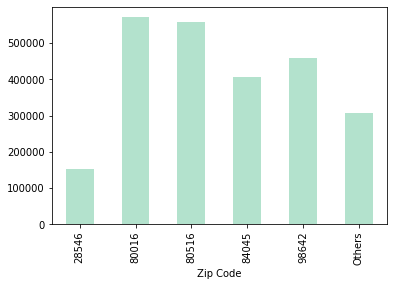

In [62]:
def filter_resample(df, zip):
  filtered_df = df[df['postal_code'] == zip]
  resampled_filtered = filtered_df.groupby(['time']).mean()
  return resampled_filtered

def plot_em(df, col, zipcodes):
  baseline_postal_code = df.loc[df['value'] == df['value'].max()].postal_code.unique()
  target_df = pd.Series(df.loc[df.postal_code.isin(zipcodes)].set_index('postal_code')[col])
  
  target_df['Others'] = df.loc[~df.postal_code.isin(zipcodes), col].mean()

  ax = target_df.plot.bar(cmap='Pastel2')
  ax.set_xlabel('Zip Code')

  '''
  fig, axs = plt.subplots(nrows=len(cols), figsize=(15,15))
  for ax, col in zip(axs, cols):
    baseline_df[col].plot(ax=ax, c='black')
    target_df[col].plot(ax=ax, c='r')
    ax.set_title(str(zipcode)+' '+col)
    ax.legend()
  '''
new = filtered_df.groupby('postal_code').mean()
cols = ['value','pending_ratio_mm','price_increased_count_mm','median_days_on_market_mm']
plot_em(new.reset_index(), 'value',[84045, 98642, 28546, 80016, 80516])  


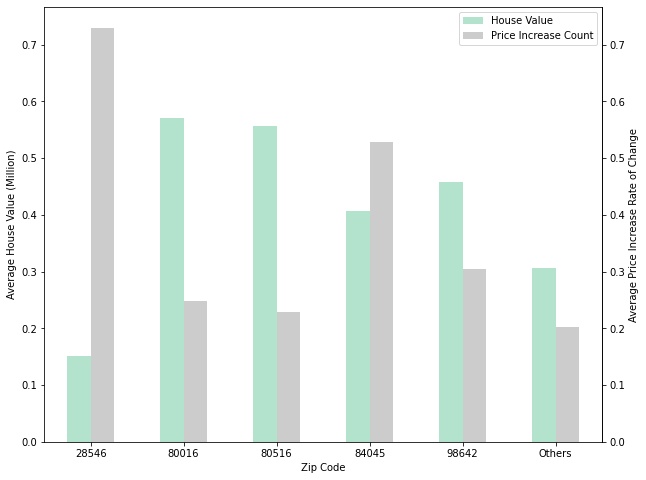

In [79]:
def plot_em(df, cols, zipcodes):
  target_df = df.loc[df.postal_code.isin(zipcodes),cols+['postal_code']].set_index('postal_code')
  others = df.loc[~df.postal_code.isin(zipcodes), cols].mean()
  target_df.loc["Others"] = others.values
  target_df['value'] = target_df['value']/1000000
  target_df = target_df.rename(columns={'value': 'House Value', 'price_increased_count_mm':'Price Increase Count'})
  ax = target_df.plot.bar(cmap='Pastel2',figsize=(10,8))
  ax.set_ylabel('Average House Value (Million)')
  sec_yaxis = ax.secondary_yaxis(location='right')
  sec_yaxis.set_ylabel("Average Price Increase Rate of Change")

  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
  
  ax.set_xlabel('Zip Code')
plot_em(new.reset_index(), ['value', 'price_increased_count_mm'],[84045, 98642, 28546, 80016, 80516]) 

                                 0  median_days_on_market_mm  pending_ratio_mm
28546                          NaN                  0.011568          0.157283
80016                          NaN                  0.040345          0.066588
80516                          NaN                  0.059299          0.099205
84045                          NaN                  0.082466          0.295388
98642                          NaN                  0.027138          0.129953
Others                         NaN                  0.011317          0.056378
pending_ratio_mm          0.056378                       NaN               NaN
median_days_on_market_mm  0.011317                       NaN               NaN


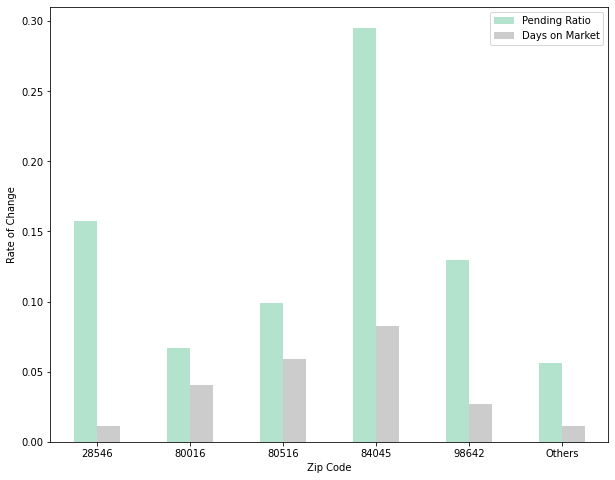

In [74]:
def plot_em(df, cols, zipcodes):
  target_df = df.loc[df.postal_code.isin(zipcodes),cols+['postal_code']].set_index('postal_code')
  others_avg = df.loc[~df.postal_code.isin(zipcodes),cols].mean()
  target_df.loc['Others',:] = others_avg.values
  
  target_df = target_df.rename(columns={'pending_ratio_mm':'Pending Ratio', 'median_days_on_market_mm':'Days on Market'})
  ax = target_df.plot.bar(cmap='Pastel2',figsize=(10,8))
  ax.set_ylabel("Rate of Change")
  
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
  
  ax.set_xlabel('Zip Code')
plot_em(new.reset_index(), ['pending_ratio_mm','median_days_on_market_mm'],[84045, 98642, 28546, 80016, 80516]) 

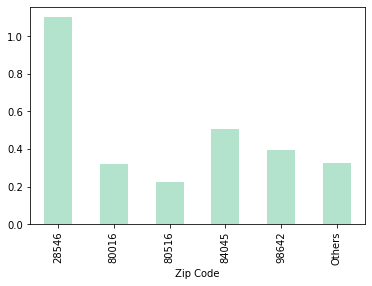

In [ ]:
plot_em(new.reset_index(), 'price_increased_count_mm',[84045, 98642, 28546, 80016, 80516])  

## MPL Regression

In [60]:
from sklearn.neural_network import MLPRegressor
import math
import datetime as dt
import pandas as pd
import numpy as np

def segment_data(X,y):
    index_range, split_index = np.arange(len(X)), math.ceil(len(X)*.8)
    train_index, test_index = index_range[:split_index], index_range[split_index:]
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return (X_train, y_train), (X_test, y_test)

def calc_rmse(y_hat,y_true):
  sum_squared_diff = np.sum([(y_pred-y)**2 for y_pred,y_true in zip(y_hat,y_true)])
  return sum_squared_diff**0.5


def mpl_regressor(X,y, model_kwargs={}):
    '''
    ---------------------------------------------------------------------
    model: uninitalized model- no parantheses 
    model_kwargs: keyword arguments to pass into the model before fitting
    ---------------------------------------------------------------------
    Returns: test rmse
    '''
    (X_train, y_train), (X_test,y_test) = segment_data(X,y)
    regr = MLPRegressor(**model_kwargs).fit(X_train, y_train)
    
    _X_test = X_test[X_test['postal_code'] == 84045]
    _y_test = y_test[_X_test.index]
    
    predictions = regr.predict(_X_test.values)
    rmse = calc_rmse(predictions,_y_test)
    return rmse


merged = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/zillow_and_rdc.csv')
merged['time'] = pd.to_datetime(merged['time'])
after_2018 = merged[merged['time'].dt.year >=2019]
filtered_df = merged.groupby(['postal_code']).filter(lambda x:len(x) >= 25).set_index(['time','postal_code'])
cols = 'value	median_days_on_market	median_days_on_market_mm	median_days_on_market_yy	new_listing_count	new_listing_count_mm	new_listing_count_yy	price_increased_count	price_increased_count_mm	price_increased_count_yy	price_reduced_count	price_reduced_count_mm	price_reduced_count_yy	pending_ratio	pending_ratio_mm	pending_ratio_yy'.split()
_df_scaled = pd.DataFrame(StandardScaler().fit_transform(filtered_df[cols]), index = filtered_df.index, columns=cols).reset_index()



_df = _df_scaled.reset_index().copy()
target_df = _df.sort_values(by='time').drop(columns=['time', 'index']) 
X, y = target_df.drop(columns='value'), target_df['value']

mpl_regressor(X,y, {'learning_rate':'adaptive'
                      ,'max_iter': 300
                      ,'solver':'adam'
                      ,'shuffle':False})

684.009368957799